In [17]:
import numpy as np
import pandas as pd
import hvplot.pandas
from xgboost import XGBRegressor
%matplotlib inline

In [18]:
# Load the fear and greed sentiment data for AAPL
df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [19]:
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [20]:
df["Pct_change"] = df["Adj Close"].pct_change()
df.dropna(inplace = True)
df.head()


,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000


In [21]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [22]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 1 is the `Close` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)


In [23]:
X

array([[  23.83,   23.36,   22.38, ..., 1430.  , 1949.  , 2289.  ],
       [  23.36,   22.38,   22.5 , ..., 1949.  , 2289.  , 2235.  ],
       [  22.38,   22.5 ,   22.86, ..., 2289.  , 2235.  , 1222.  ],
       ...,
       [  50.16,   51.12,   50.54, ..., 1103.  ,  888.  ,  962.  ],
       [  51.12,   50.54,   50.88, ...,  888.  ,  962.  ,  895.  ],
       [  50.54,   50.88,   51.74, ...,  962.  ,  895.  , 1083.  ]])

In [24]:
y.shape

(918, 1)

In [25]:
# Use 70% of the data for training and the remaineder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


In [27]:
# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)


In [28]:
# Fit the model
model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

---

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [29]:
# Make some predictions
predicted = model.predict(X_test)

In [30]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [31]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.278919
2018-07-30,46.13,45.850250
2018-07-31,46.22,46.335159
2018-08-01,48.95,45.903019
2018-08-02,50.38,48.946972


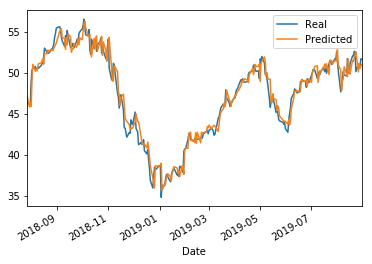

In [32]:
# Plot the real vs predicted values as a line chart
stocks.plot()